# Import Sionna & Others

---



In [ ]:
import os
gpu_num = 0 # Use "" to use the CPU
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Colab does currently not support the latest version of ipython.
# Thus, the preview does not work in Colab. However, whenever possible we
# strongly recommend to use the scene preview mode.
try: # detect if the notebook runs in Colab
    import google.colab
    colab_compat = True # deactivate preview
except:
    colab_compat = False
resolution = [480,320] # increase for higher quality of renderings

# Allows to exit cell execution in Jupyter
class ExitCell(Exception):
    def _render_traceback_(self):
        pass

# Import Sionna
try:
    import sionna
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna

# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)
# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')

tf.random.set_seed(1) # Set global random seed for reproducibility


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time

# Import Sionna RT components
from sionna.rt import load_scene, Transmitter, Receiver, PlanarArray, Camera

# For link-level simulations
from sionna.channel import cir_to_ofdm_channel, subcarrier_frequencies, OFDMChannel, ApplyOFDMChannel, CIRDataset
from sionna.nr import PUSCHConfig, PUSCHTransmitter, PUSCHReceiver
from sionna.utils import compute_ber, ebnodb2no, PlotBER
from sionna.ofdm import KBestDetector, LinearDetector
from sionna.mimo import StreamManagement

# Loading Scene (Custom or Pre-Made)

---



In [ ]:
# Load integrated scene
scene = load_scene(sionna.rt.scene.etoile) # Here we loaded a pre-made scene

## Setting Up Camera

---



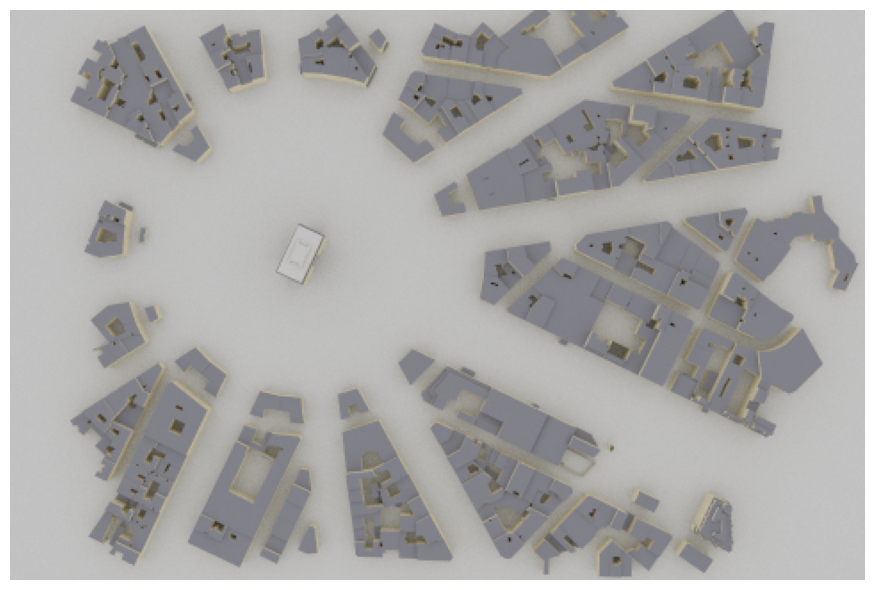

In [ ]:
# Create new camera with different configuration
scene.add(Camera("my_cam",
                     position=[0,0,1000],
                     orientation=[0,np.pi/2,-np.pi/2]))
scene.bandwidth=100e6
# Render scene with new camera*
scene.render("my_cam", resolution=resolution, num_samples=512); # Increase num_samples to increase image quality

## Setting Up Transmitters & Receivers
Here I considered **3 Transmitters** (Tx) and **1 Receiver** (Rx) for this simulation

---



In [ ]:
# Remove transmitters and receivers so that we can simulate it for multiple times
scene.remove('tx1')
scene.remove('tx2')
scene.remove('tx3')
scene.remove('rx')

# Configure antenna array for all transmitters
scene.tx_array = PlanarArray(num_rows=1,
                             num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="tr38901",
                             polarization="V")

# Configure antenna array for all receivers
scene.rx_array = PlanarArray(num_rows=1,
                             num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="dipole",
                             polarization="cross")

# Create transmitter
tx1 = Transmitter(name="tx1",
                 position=[-150.3, 21.63, 42.5])
tx2 = Transmitter(name="tx2",
                 position=[232.8, -95.5, 17])
tx3 = Transmitter(name="tx3",
                 position=[172.1, 103.7, 24])

# Add transmitter instance to scene
scene.add(tx1)
scene.add(tx2)
scene.add(tx3)

# Create a receiver
rx = Receiver(name="rx",
              position=[-94.5, 64.94, 22.5],
              orientation=[0,0,0])

# Add receiver instance to scene
scene.add(rx)

tx1.look_at(rx) # Transmitter points towards receiver
tx2.look_at(rx)
tx3.look_at(rx)

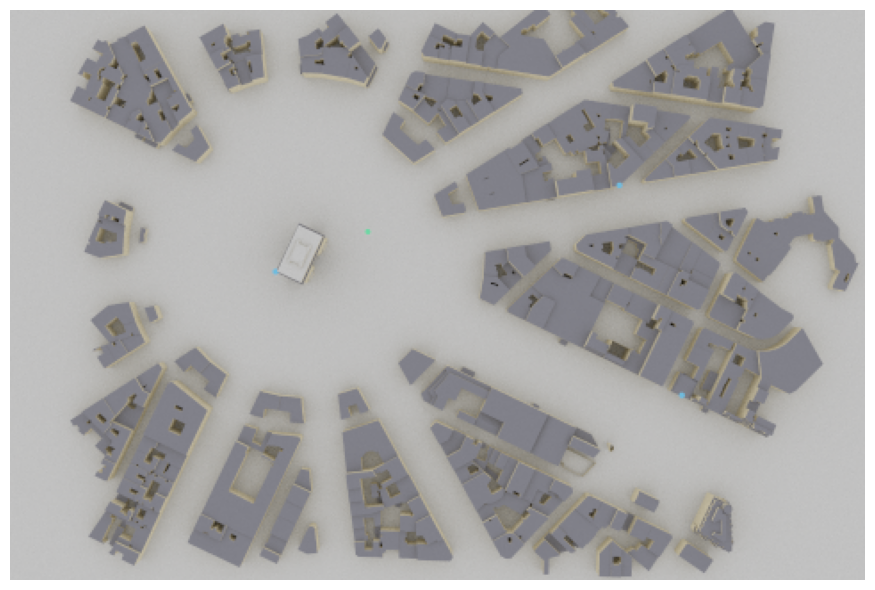

In [ ]:
# Create new camera with different configuration
scene.add(Camera("my_cam",
                     position=[0,0,1000],
                     orientation=[0,np.pi/2,-np.pi/2]))
scene.bandwidth=100e6
scene.render("my_cam", resolution=resolution, num_samples=512);

Another Camera Angle:

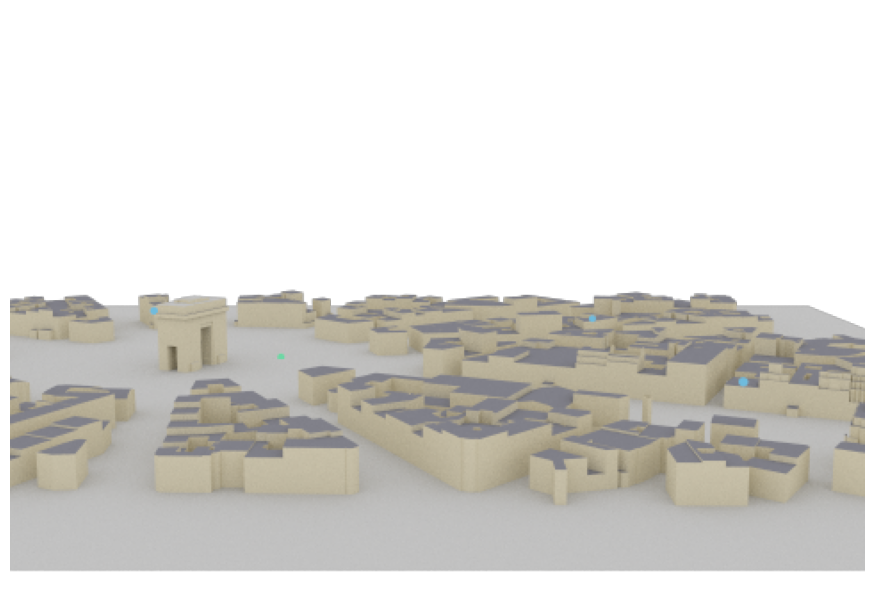

In [ ]:
scene.remove('my_cam1')
# Create new camera with different configuration
scene.add(Camera("my_cam1",
                     position=[50, -700, 150],
                     #orientation=[-np.pi/4, 0, 0],
                     look_at=[50, 50, 50]))
scene.bandwidth=100e6
scene.render("my_cam1", resolution=resolution, num_samples=512);

Another Camera Angle:

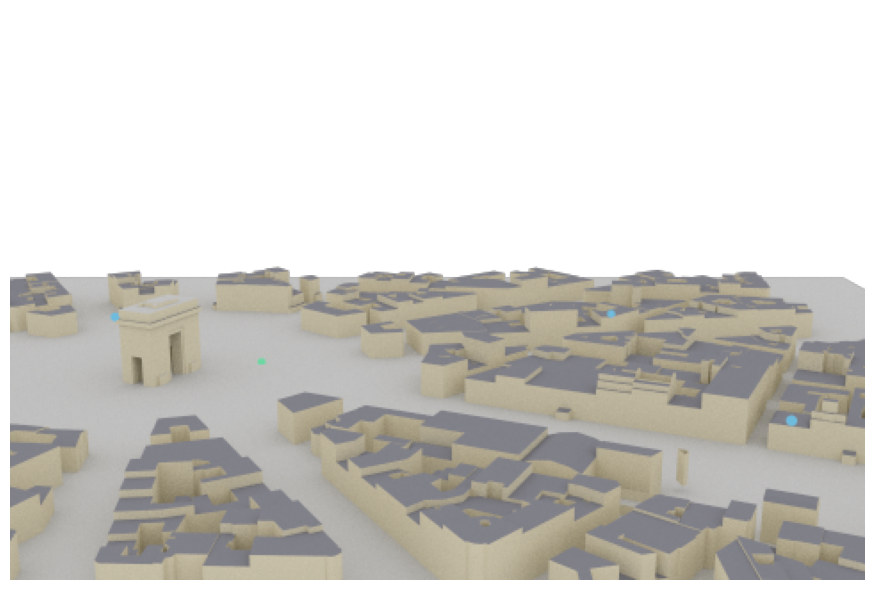

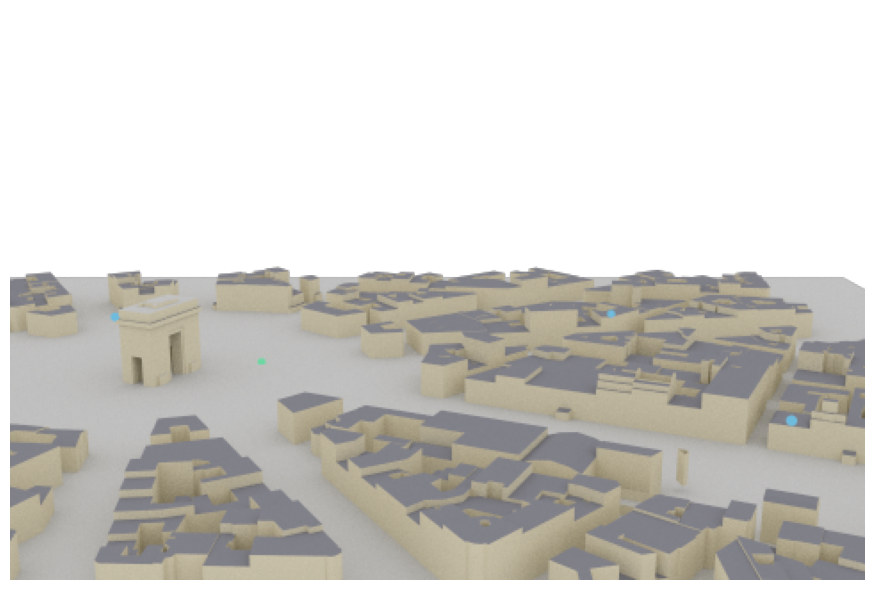

In [ ]:
scene.remove('my_cam2')
# Adjust the camera for a closer and higher view
scene.add(Camera("my_cam2",
                 position=[50, -600, 200],  # Move closer and higher
                 look_at=[50, 50, 50]))  # Keep the look_at point centered

# Render the scene with the updated camera configuration
scene.render("my_cam2", resolution=resolution, num_samples=512)

## Computing SINR Using Coverage Maps!!
New feature of Sionna V0.19.0

---



A coverage map assigns a metric, such as path gain, received signal strength (RSS), or signal-to-interference-plus-noise ratio (SINR), for a specific transmitter to every point on a plane. In other words, for a given transmitter, it associates every point on a surface with the channel gain, RSS, or SINR, that a receiver with a specific orientation would observe at this point.

A coverage map depends on the transmit and receive arrays and their respective antenna patterns, the transmitter and receiver orientations, as well as the transmit precoding and receive combining vectors. Moreover, a coverage map is not continuous but discrete, as the plane must be quantized into small rectangular bins, which we refer to as cells.


---
As soon as there are multiple transmitters in a scene, we can either visualize a metric for specific transmitter or visualize the maximum matric across all transmitters. **The latter option is relevant if we want to inspect, e.g., the SINR across a large scene, assuming that a receiver always connects to the transmitter providing the best SINR**.


In [ ]:
# Compute the SINR map
cm_etoile = scene.coverage_map(
    max_depth=7,
    los=True,
    reflection=True,
    diffraction=True,
    cm_cell_size=(1, 1),
    num_samples=int(10e6),  # Decrease to reduce memory consumption
    num_runs=1)  # Increase to average over multiple coverage maps to reduce noise

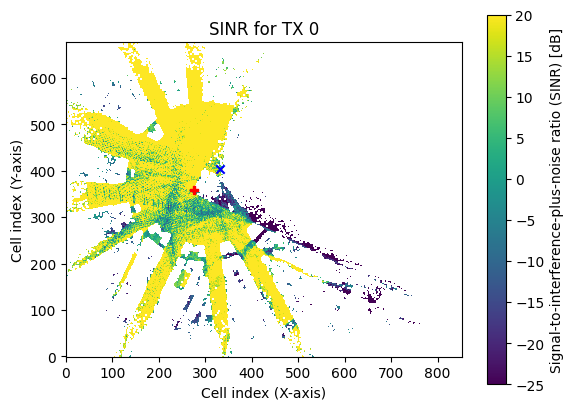

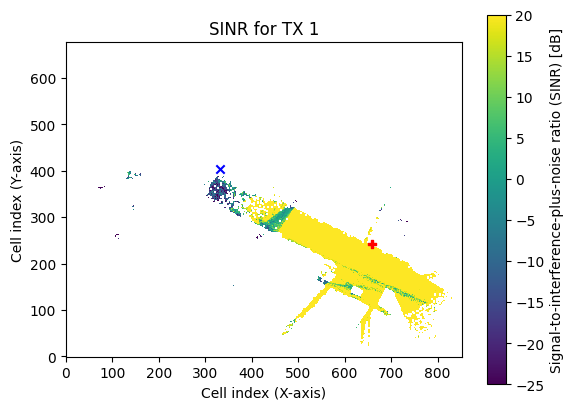

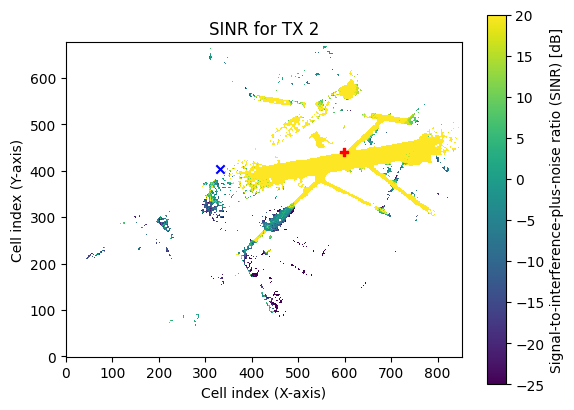

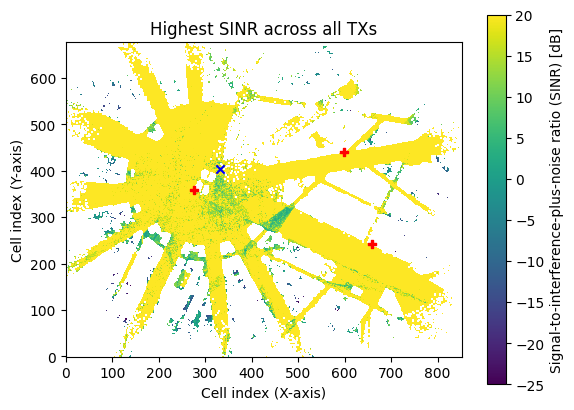

In [ ]:
# Show SINR for individual transmitters
# show_rx=True add the receiver in the plot
cm_etoile.show(metric="sinr", tx=0, vmin=-25, vmax=20,show_rx=True);
cm_etoile.show(metric="sinr", tx=1, vmin=-25, vmax=20,show_rx=True);
cm_etoile.show(metric="sinr", tx=2, vmin=-25, vmax=20,show_rx=True);

# Show maximum SINR across all transmitters
cm_etoile.show(metric="sinr", tx=None, vmin=-25, vmax=20,show_rx=True);

**It is also interesting to investigate which regions of a coverage map are “covered” by each transmitter, i.e., where a transmitter provides the strongest metric. You can obtain this information either as a tensor from the class method `cell_to_tx()` or visualize it using `show_association()`.**

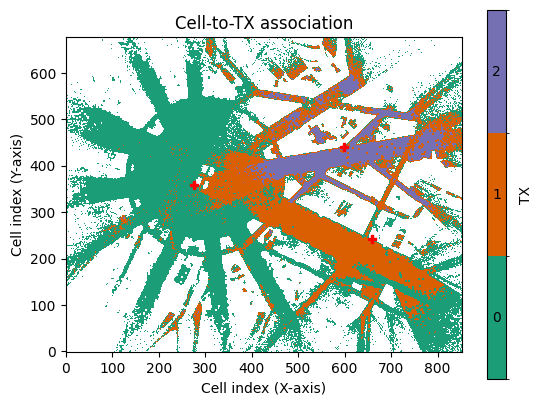

In [ ]:
cm_etoile.show_association("sinr");

# Simulation

---






## Simulation 1: DT Based Handover




Beginning transmission with the receiver from the best transmitter (Providing best SINR)


---

### Logic behind the simulation:
Computing the SINR at a given position. In principle, you could compute coverage maps for all transmitters in the scene and then compute for each transmitter's SINR Map. Users would always seek to handover to another transmitter when the SINR is too low.

You would not even need to compute propagation paths with this approach and simply compute the coverage maps once.


---



**Creating Necessary Function:**

In [ ]:
'''
This approach:

1) Converts the world position to the local coordinate system of the coverage map.

2) Shifts the origin to match the coverage map's coordinate system.

3) Calculates the cell indices by dividing the local position by the cell size.

4) Ensures the indices are within the bounds of the coverage map.

5) Retrieves the SINR values for all transmitters at that cell.

Output:

This gives you the SINR values for all transmitters at the specified position,
which you can use for handover decisions or other analyses.

You're getting three SINR values because there are three transmitters in the scene.
Each value represents the SINR for a different transmitter at the given position.
'''
from sionna.rt.utils import rotation_matrix
def get_sinr_at_position(coverage_map, position):
    # Convert position to local coordinates relative to coverage map center
    local_pos = position[:2] - coverage_map._center[:2]

    # Get cell size and map size
    cell_size = coverage_map._cell_size
    map_size = coverage_map._size

    # Shift to coverage map coordinate system
    local_pos += map_size / 2

    # Calculate cell indices
    cell_indices = tf.cast(local_pos / cell_size, tf.int32)

    # Clip indices to valid range
    cell_indices = tf.clip_by_value(
        cell_indices,
        [0, 0],
        [tf.shape(coverage_map.sinr)[2] - 1, tf.shape(coverage_map.sinr)[1] - 1]
    )

    # Get SINR values for all transmitters at this cell
    # Shape: [num_tx]
    sinr_values = coverage_map.sinr[:, cell_indices[1], cell_indices[0]]

    # Convert to dB
    sinr_db = 10 * tf.math.log(sinr_values) / tf.math.log(10.0)

    return sinr_db.numpy()


### Showing best serving transmitters
Three Example Cases as there are three transmiiters:

**Best Serving Transmitter: 02**


---



SINR at position [-14.5, 54.94, 42.5]: [     -inf      -inf 61.645687] dB
Best transmitter is 2 with SINR = 61.645687103271484 dB


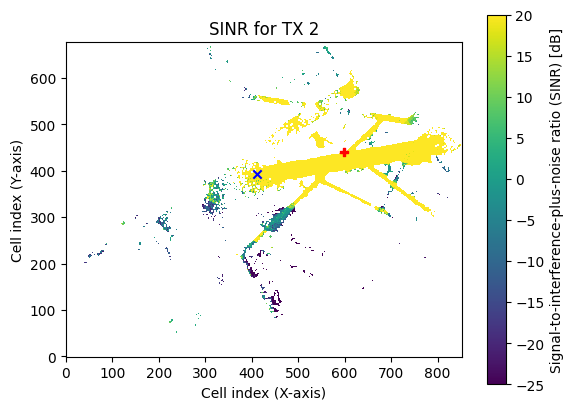

In [ ]:
scene.remove('rx')
# Usage
position = [-14.5, 54.94, 42.5]  # Your specific position

# Create a receiver
rx = Receiver(name="rx",
              position=position,
              orientation=[0,0,0])

# Add receiver instance to scene
scene.add(rx)

sinr_at_position = get_sinr_at_position(cm_etoile, position)
print(f"SINR at position {position}: {sinr_at_position} dB")

best_tx_index = np.argmax(sinr_at_position)
best_sinr = sinr_at_position[best_tx_index]
print(f"Best transmitter is {best_tx_index} with SINR = {best_sinr} dB")

# Show SINR Coverage Map for the best transmitter
cm_etoile = scene.coverage_map(
    max_depth=7,
    los=True,
    reflection=True,
    diffraction=True,
    cm_cell_size=(1, 1),
    num_samples=int(10e6),  # Decrease to reduce memory consumption
    num_runs=1)  # Increase to average over multiple coverage maps to reduce noise
cm_etoile.show(metric="sinr", tx=int(best_tx_index), vmin=-25, vmax=20,show_rx=True);

Showing the other transmitters why they are not the best to start transmission:

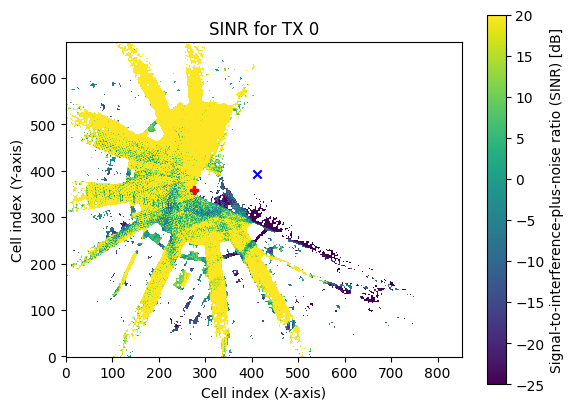

In [ ]:
cm_etoile.show(metric="sinr", tx=0, vmin=-25, vmax=20,show_rx=True);

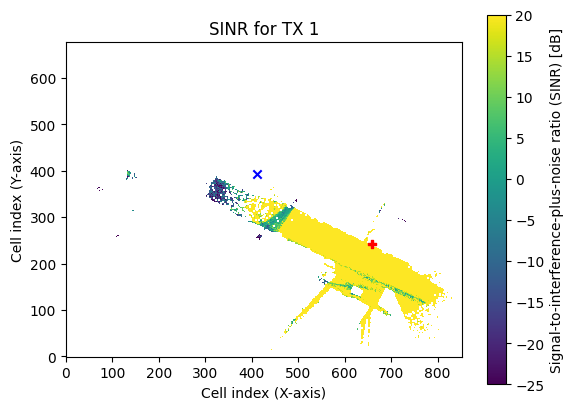

In [ ]:
cm_etoile.show(metric="sinr", tx=1, vmin=-25, vmax=20,show_rx=True);

**Best Serving Transmitter: 00**


---



SINR at position [-120.3, 151.63, 42.5]: [ 27.68368  -27.706331 -51.517902] dB
Best transmitter is 0 with SINR = 27.683679580688477 dB


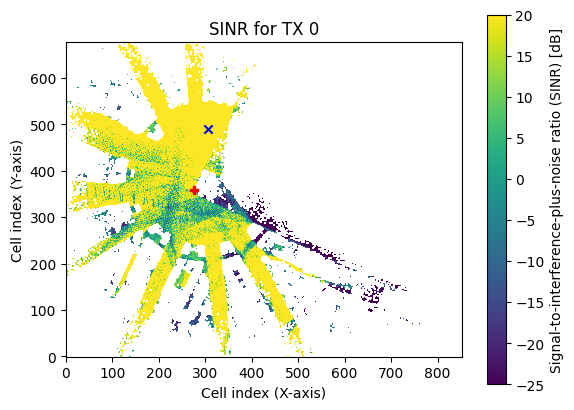

In [ ]:
scene.remove('rx')
# Usage
position = [-120.3, 151.63, 42.5]  # Your specific position

# Create a receiver
rx = Receiver(name="rx",
              position=position,
              orientation=[0,0,0])

# Add receiver instance to scene
scene.add(rx)

sinr_at_position = get_sinr_at_position(cm_etoile, position)
print(f"SINR at position {position}: {sinr_at_position} dB")

best_tx_index = np.argmax(sinr_at_position)
best_sinr = sinr_at_position[best_tx_index]
print(f"Best transmitter is {best_tx_index} with SINR = {best_sinr} dB")

# Show SINR Coverage Map for the best transmitter
cm_etoile = scene.coverage_map(
    max_depth=7,
    los=True,
    reflection=True,
    diffraction=True,
    cm_cell_size=(1, 1),
    num_samples=int(10e6),  # Decrease to reduce memory consumption
    num_runs=1)  # Increase to average over multiple coverage maps to reduce noise
cm_etoile.show(metric="sinr", tx=int(best_tx_index), vmin=-25, vmax=20,show_rx=True);

Showing the other transmitters why they are not the best to start transmission:

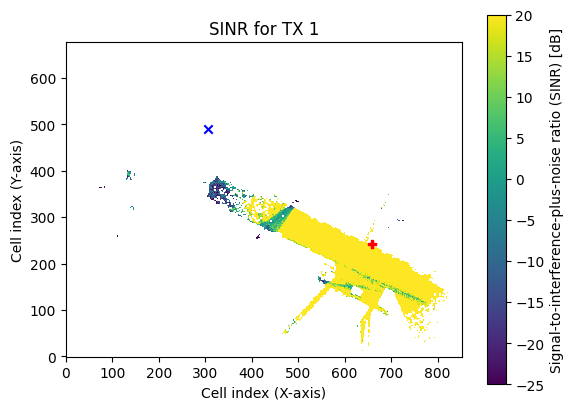

In [ ]:
cm_etoile.show(metric="sinr", tx=1, vmin=-25, vmax=20,show_rx=True);

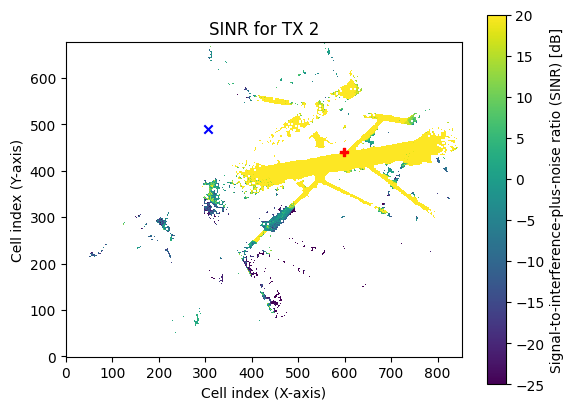

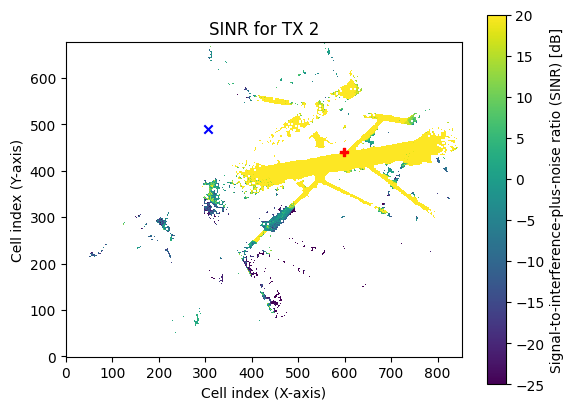

In [ ]:
cm_etoile.show(metric="sinr", tx=2, vmin=-25, vmax=20,show_rx=True)

**Best Serving Transmitter: 01**


---



SINR at position [190.8, -145.5, 17]: [-28.56028   28.537056       -inf] dB
Best transmitter is 1 with SINR = 28.53705596923828 dB


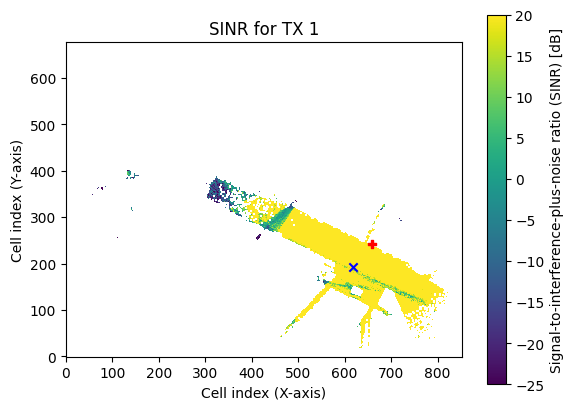

In [ ]:
scene.remove('rx')
# Usage
position = [190.8, -145.5, 17]  # Your specific position

# Create a receiver
rx = Receiver(name="rx",
              position=position,
              orientation=[0,0,0])

# Add receiver instance to scene
scene.add(rx)

sinr_at_position = get_sinr_at_position(cm_etoile, position)
print(f"SINR at position {position}: {sinr_at_position} dB")

best_tx_index = np.argmax(sinr_at_position)
best_sinr = sinr_at_position[best_tx_index]
print(f"Best transmitter is {best_tx_index} with SINR = {best_sinr} dB")

# Show SINR Coverage Map for the best transmitter
cm_etoile = scene.coverage_map(
    max_depth=7,
    los=True,
    reflection=True,
    diffraction=True,
    cm_cell_size=(1, 1),
    num_samples=int(10e6),  # Decrease to reduce memory consumption
    num_runs=1)  # Increase to average over multiple coverage maps to reduce noise
cm_etoile.show(metric="sinr", tx=int(best_tx_index), vmin=-25, vmax=20,show_rx=True);

Showing the other transmitters why they are not the best to start transmission:

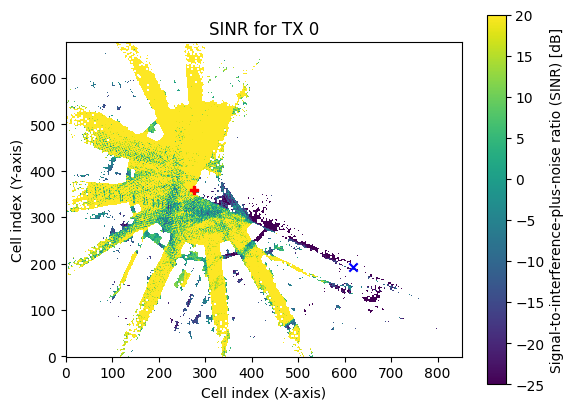

In [ ]:
cm_etoile.show(metric="sinr", tx=0, vmin=-25, vmax=20,show_rx=True);

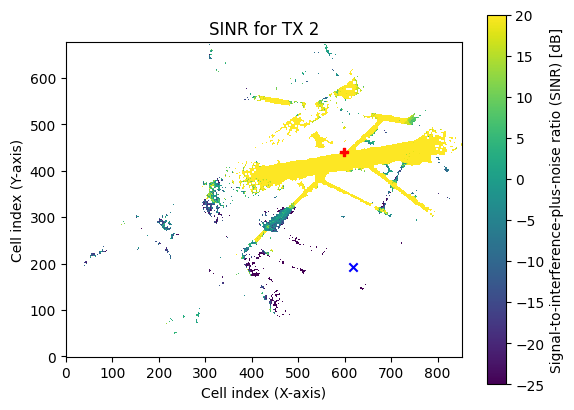

In [ ]:
cm_etoile.show(metric="sinr", tx=2, vmin=-25, vmax=20,show_rx=True);

## Simulation 2: DT vs Distance Based Handover


---



### Logic Behind the simulation:
User having high BER/low SINR, even after handover to the nearest transmitter is that there is some link blockage such as buildings  that result  in huge path loss and shadowing and thus high BER/low SINR. In contrast, another transmitter, despite having large distance, has clear path and thus providing  better BER/ High SINR.

Particularly, distance based handover is usually  employed as it is most simple. However this distance based handover does not have any knowledge of the RF environment. Thus, it may end up associating a user to near-by BS, which has high path loss due to buildings. In contrast the digital twin avoids the case thanks to its RF environment awareness.

We can compare SINR performance of two systems: RF environment  aware DT enabled handover  and distance based handover. In the latter case, user will be alaways associated withe the nearest BS. We can show DT based handover achieves better SINR.



Position: (-300.0, -69.38775510204081, 1.5)
Nearest Transmitter: TX1, SINR: -0.26 dB
Best Transmitter: TX3, SINR: 0.26 dB

Position: (-300.0, -44.897959183673464, 1.5)
Nearest Transmitter: TX1, SINR: -20.55 dB
Best Transmitter: TX3, SINR: 20.55 dB

Position: (-300.0, -36.734693877551024, 1.5)
Nearest Transmitter: TX1, SINR: -22.27 dB
Best Transmitter: TX3, SINR: 22.27 dB

Position: (-300.0, -12.244897959183675, 1.5)
Nearest Transmitter: TX1, SINR: -9.92 dB
Best Transmitter: TX2, SINR: 9.92 dB

Position: (-300.0, 85.71428571428572, 1.5)
Nearest Transmitter: TX1, SINR: -3.66 dB
Best Transmitter: TX3, SINR: 2.51 dB

Position: (-300.0, 102.0408163265306, 1.5)
Nearest Transmitter: TX1, SINR: -7.09 dB
Best Transmitter: TX2, SINR: 6.65 dB

Position: (-287.7551020408163, -69.38775510204081, 1.5)
Nearest Transmitter: TX1, SINR: -0.26 dB
Best Transmitter: TX3, SINR: 0.26 dB

Position: (-287.7551020408163, -44.897959183673464, 1.5)
Nearest Transmitter: TX1, SINR: -20.55 dB
Best Transmitter: TX3, 

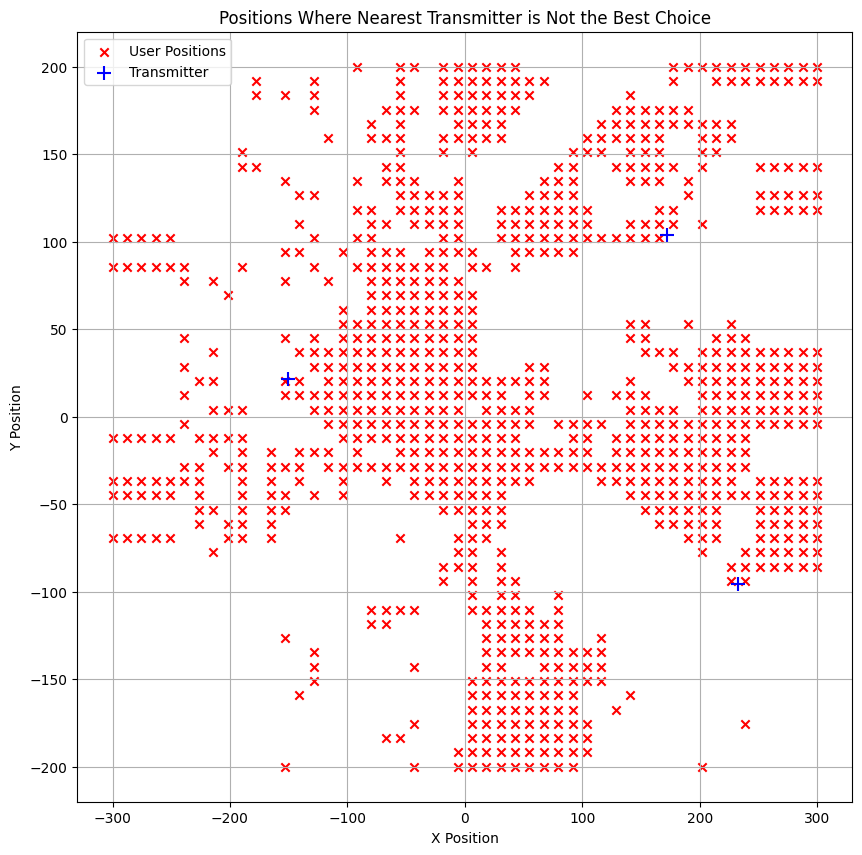

In [ ]:
'''
In this code, I'm trying to calculate the user positions in the scene where the nearest transmitter is not the best choice.
On that positions, distant transmitters provide better SINR than the nearest transmitter.
'''
import numpy as np
import matplotlib.pyplot as plt
from sionna.rt import load_scene, Transmitter, Receiver, PlanarArray

# Load the etoile scene
scene = load_scene(sionna.rt.scene.etoile)

# Add transmitters
tx_positions = [
    [-150.3, 21.63, 42.5],
    [232.8, -95.5, 17],
    [172.1, 103.7, 24]
]

for i, pos in enumerate(tx_positions):
    tx = Transmitter(name=f"tx{i+1}", position=pos, power_dbm=44)
    scene.add(tx)

# Configure antenna arrays
scene.tx_array = PlanarArray(num_rows=4, num_cols=4, vertical_spacing=0.5, horizontal_spacing=0.5, pattern="iso", polarization="V")
scene.rx_array = PlanarArray(num_rows=1, num_cols=1, vertical_spacing=0.5, horizontal_spacing=0.5, pattern="iso", polarization="V")

# Compute coverage map for the etoile scene
coverage_map = scene.coverage_map(
    num_samples=2e6,
    max_depth=5,
    los=True,
    reflection=True,
    diffraction=True,
    cm_cell_size=[4, 4],
    cm_orientation=[0, 0, 0],
    cm_center=[0, 0, 1.5],
    cm_size=[500, 500]
)

# Define a function to calculate distance
def calculate_distance(pos1, pos2):
    return np.linalg.norm(np.array(pos1) - np.array(pos2))

# Create a grid of potential user positions
x_range = np.linspace(-300, 300, 50)
y_range = np.linspace(-200, 200, 50)
grid_positions = [(x, y, 1.5) for x in x_range for y in y_range]

# Find positions where the nearest transmitter is not the best choice
selected_positions = []

for position in grid_positions:
    # Add receiver to the scene
    receiver = Receiver(name="rx", position=position)
    scene.add(receiver)

    # Calculate SINR values
    sinr_values = get_sinr_at_position(coverage_map, position)

    # Distance-based handover
    distances = [calculate_distance(position, tx_pos) for tx_pos in tx_positions]
    nearest_tx_index = np.argmin(distances)

    # DT-enabled handover
    best_tx_index = np.argmax(sinr_values)

    # Check if the nearest transmitter is not the best choice
    if nearest_tx_index != best_tx_index:
        selected_positions.append(position)
        print(f"Position: {position}")
        print(f"Nearest Transmitter: TX{nearest_tx_index+1}, SINR: {sinr_values[nearest_tx_index]:.2f} dB")
        print(f"Best Transmitter: TX{best_tx_index+1}, SINR: {sinr_values[best_tx_index]:.2f} dB\n")

    # Remove receiver from the scene
    scene.remove("rx")

# Visualize the selected positions
plt.figure(figsize=(10, 10))
plt.scatter([], [], color='red', marker='x', label='User Positions')
plt.scatter([], [], color='blue', marker='+', s=100, label='Transmitter')
for pos in selected_positions:
    plt.scatter(pos[0], pos[1], color='red', marker='x')
for tx_pos in tx_positions:
    plt.scatter(tx_pos[0], tx_pos[1], color='blue', marker='+', s=100)
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('Positions Where Nearest Transmitter is Not the Best Choice')
plt.legend()
plt.grid(True)
plt.show()

### Example Cases:

---



SINR at position (-128.57142857142858, 12.244897959183675, 1.5): [-22.75276  -15.844318  15.000079] dB
Best transmitter is 2 with SINR = 15.000079154968262 dB


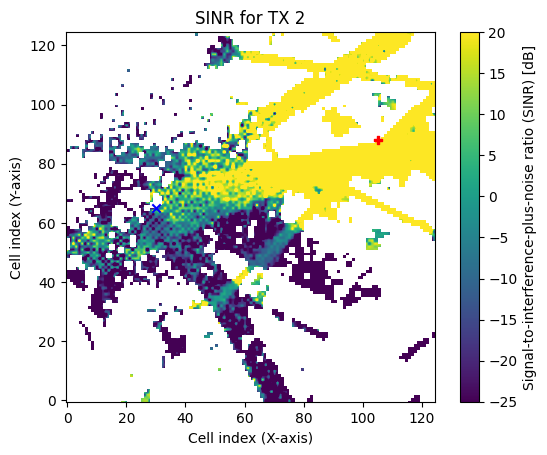

In [ ]:
scene.remove('rx')
# Usage
position = (-128.57142857142858, 12.244897959183675, 1.5)  # Your specific position

# Create a receiver
rx = Receiver(name="rx",
              position=position,
              orientation=[0,0,0])

# Add receiver instance to scene
scene.add(rx)

sinr_at_position = get_sinr_at_position(coverage_map, position)
print(f"SINR at position {position}: {sinr_at_position} dB")

best_tx_index = np.argmax(sinr_at_position)
best_sinr = sinr_at_position[best_tx_index]
print(f"Best transmitter is {best_tx_index} with SINR = {best_sinr} dB")

# Show SINR Coverage Map for the best transmitter
coverage_map = scene.coverage_map(
    num_samples=2e6,
    max_depth=5,
    los=True,
    reflection=True,
    diffraction=True,
    cm_cell_size=[4, 4],
    cm_orientation=[0, 0, 0],
    cm_center=[0, 0, 1.5],
    cm_size=[500, 500]
)
coverage_map.show(metric="sinr", tx=int(best_tx_index), vmin=-25, vmax=20,show_rx=True);

Nearest transmitter is not the best because:

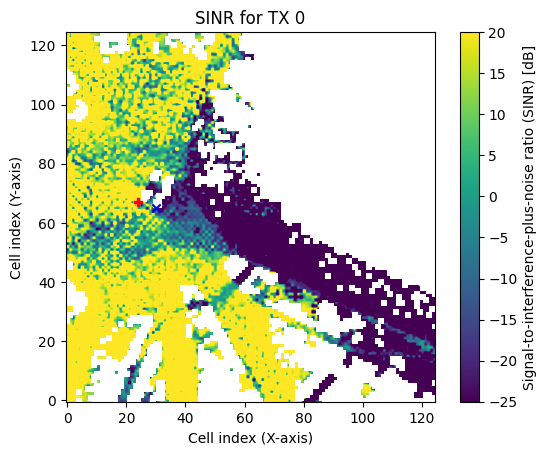

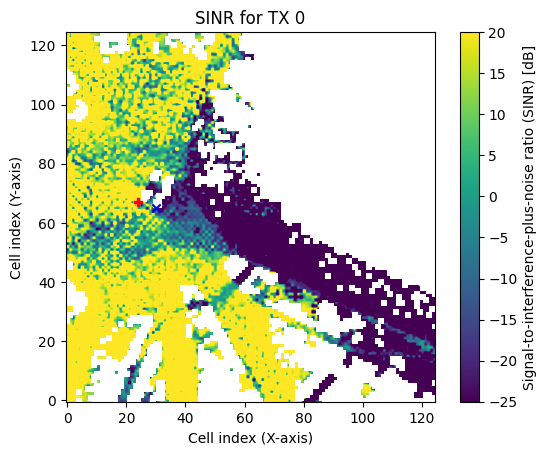

In [ ]:
coverage_map.show(metric="sinr", tx=0, vmin=-25, vmax=20,show_rx=True)

Another Example:

SINR at position (-67.34693877551021, 61.22448979591837, 1.5): [-26.16755     1.6144828  -1.6578747] dB
Best transmitter is 1 with SINR = 1.6144827604293823 dB


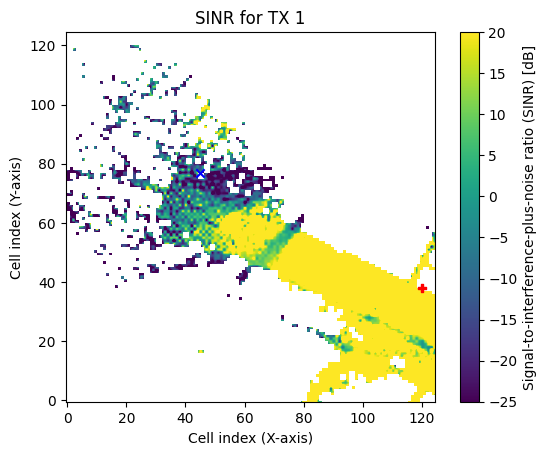

In [ ]:
scene.remove('rx')
# Usage
position = (-67.34693877551021, 61.22448979591837, 1.5)  # Your specific position

# Create a receiver
rx = Receiver(name="rx",
              position=position,
              orientation=[0,0,0])

# Add receiver instance to scene
scene.add(rx)

sinr_at_position = get_sinr_at_position(coverage_map, position)
print(f"SINR at position {position}: {sinr_at_position} dB")

best_tx_index = np.argmax(sinr_at_position)
best_sinr = sinr_at_position[best_tx_index]
print(f"Best transmitter is {best_tx_index} with SINR = {best_sinr} dB")

# Show SINR Coverage Map for the best transmitter
coverage_map = scene.coverage_map(
    num_samples=2e6,
    max_depth=5,
    los=True,
    reflection=True,
    diffraction=True,
    cm_cell_size=[4, 4],
    cm_orientation=[0, 0, 0],
    cm_center=[0, 0, 1.5],
    cm_size=[500, 500]
)
coverage_map.show(metric="sinr", tx=int(best_tx_index), vmin=-25, vmax=20,show_rx=True);

Nearest transmitter is not the best because:

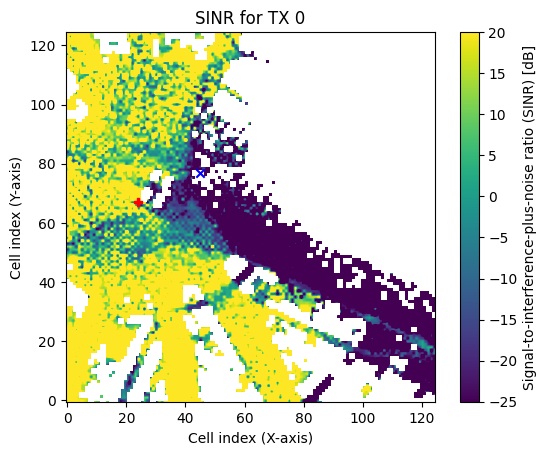

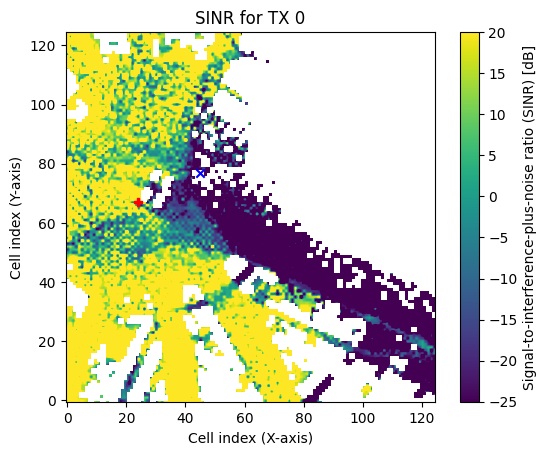

In [ ]:
coverage_map.show(metric="sinr", tx=0, vmin=-25, vmax=20,show_rx=True)